### Case Study 3 : Spam classifier

Submitted by:

- Ravi Sivaraman
- Balaji Avvaru
- Apurv Mittal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from os.path import isfile
import email
#import BeautifulSoup
from bs4 import BeautifulSoup
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import silhouette_score
import hdbscan
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn import metrics as mt
from sklearn.feature_extraction import text
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [2]:
# location of emails
data_path = "/Users/ravis/Downloads/SpamAssassinMessages"
# get all sub folders
sub_folders = [x[0] for x in os.walk(data_path) if x[0] != data_path]

In [3]:
%%time
# read all emails from all sub folders
mail_ty = []
text_ty = []
data = []
target = []

for folder in sub_folders:
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for file in files:
        with open(f"{folder}/{file}", encoding="latin1") as f:
            #    with open(f"{folder}/{file}","r") as f:
            x = email.message_from_file(f)
          #  print(x)
    #    if (file != 'cmds'): 
    #        mail_data.append(lines)
            
        mail_type = x.get_content_type()
        text_type = x.get_content_charset()
        mail_ty.append(mail_type)
        text_ty.append(text_type)
        if re.search("spam", folder):
            target.append(1)
        else:
             target.append(0)
                               
        if mail_type == "text/html":
            tmp = BeautifulSoup(x.get_payload(), 'html.parser')
            tmp = tmp.text.replace("\n", " ")
            data.append(tmp)
        elif "multipart" in mail_type:
            
            multipart_data = []
            for text in x.get_payload():
                if not isinstance(text, str): 
                    if text.get_content_type() == "text/html":
                        tmp = BeautifulSoup(text.get_payload(), 'html.parser')
                        tmp = tmp.text.replace("\n", " ")
                        multipart_data.append(tmp)
                    else:
                        multipart_data.append(text.get_payload()) 
                
            multipart_email = [''.join(str(item)) for item in multipart_data]
            data.append(multipart_email)
        else:
            data.append(x.get_payload()) 
                       

CPU times: user 5.42 s, sys: 368 ms, total: 5.79 s
Wall time: 6.94 s


In [4]:
df = pd.DataFrame()

In [5]:
df["mail_types"] = mail_ty
df["text_types"] = text_ty

In [6]:
# Count of mail types           
df["mail_types"].value_counts()

text/plain                     7413
text/html                      1193
multipart/alternative           326
multipart/signed                180
multipart/mixed                 179
multipart/related                56
multipart/report                  5
text/plain charset=us-ascii       1
Name: mail_types, dtype: int64

In [7]:
# Count of text types
df["text_types"].value_counts()

us-ascii           3275
iso-8859-1         1958
windows-1252        197
iso-8859-15         104
utf-8                22
default              15
iso-8859-2           13
gb2312               11
windows-1251         11
default_charset      10
iso-2022-jp           8
ks_c_5601-1987        7
windows-1254          6
koi8-r                6
iso-8859-9            4
unknown-8bit          2
iso-8859-3            1
gb2312_charset        1
windows-1256          1
chinesebig5           1
euc-kr                1
Name: text_types, dtype: int64

In [8]:
# Create a data frame with email text and target (whether mail is spam or not, 1 for spam and 0 for not a spam)
email_df = pd.DataFrame()
email_df["data"] = data
#email_df["mail_type"] = mail_ty
#email_df["text_type"] = text_ty
email_df["target"] = target

In [9]:
email_df['target'].value_counts()

0    6954
1    2399
Name: target, dtype: int64

In [10]:
email_df

,data,target
0,"Dear Homeowner,\n \nInterest Rates are at thei...",1
1,"[Friend,Now you can copy DVD's and Games\nhttp...",1
2,[ Pocket the newest 8 year annuity!\t Pocket t...,1
3,Congratulations! You Get a Free Handheld Orga...,1
4,ATTENTION: This is a MUST for ALL Computer Use...,1
...,...,...
9348,"I'm one of the 30,000 but it's not working ver...",0
9349,Damien Morton quoted:\n>W3C approves HTML 4 'e...,0
9350,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n> t...",0
9351,"Once upon a time, Manfred wrote :\n\n> I would...",0


In [11]:
email_df.loc[1].data

["Friend,Now you can copy DVD's and Games\nhttp://www.terra.es/personal9/iop1008/\n\nBACKUP DVD VIDEO's WITH YOUR CD-R BURNER\n\nWith 321 studio's software, you can now copy\nany DVD and Playstation Game.  Never buy another \nbackup DVD movie again.  Just copy it!\n\nThis is the first time this software is being made\navailable to the public. All the software you need \nto burn your own DVD Video, is included in 321 Studio's \nsoftware package DVD Copy Plus!  The movies will play \nin a standard DVD player. With detailed, easy to follow, \nstep-by-step instructions, you can BURN your own DVD \nVideo using nothing more than your DVD-ROM \nand CD-R drives. Purchase a copy! Click below.\n\nhttp://www.terra.es/personal9/iop1008/\n\nOrder today and receive!\n\n*Step by Step Interactive Instructions\n*All Software Tools Included On CD\n*No DVD Burner Required\n*FREE Live Technical Support\n*30 Day Risk Free Trial Available\n\nWith DVD Copy Plus you can backup Your DVD Movies with \nthe same 

In [12]:
email_df["data_new"] = [''.join(str(item)) for item in email_df.data]

In [13]:
print(email_df["data_new"][0])

Dear Homeowner,
 
Interest Rates are at their lowest point in 40 years!

We help you find the best rate for your situation by
matching your needs with hundreds of lenders!

Home Improvement, Refinance, Second Mortgage,
Home Equity Loans, and More! Even with less than
perfect credit!

This service is 100% FREE to home owners and new
home buyers without any obligation. 

Just fill out a quick, simple form and jump-start
your future plans today!


Visit http://61.145.116.186/user0201/index.asp?Afft=QM10






To unsubscribe, please visit:

http://61.145.116.186/light/watch.asp





In [14]:
# get the instanc of TfidfVectorizer
#my_stop_words = text.ENGLISH_STOP_WORDS.union(["spamassassin", "email", "message", "\n", "nbsp", "font","exhm", "subject", "list", "url", "net"])
#tf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=text.ENGLISH_STOP_WORDS)

tf_vectorizer = TfidfVectorizer()

In [15]:
# fit and transform email data
new_vectors = tf_vectorizer.fit_transform(email_df.data_new)

In [16]:
new_vectors.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03514446, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
# convert the data type from float 64 to float 32
new_vectors = new_vectors.toarray().astype('float32')

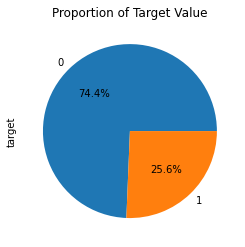

In [18]:
# Pie chart
email_df.target.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

### Clustering

#### KMeans Clustering

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity

KMeans Clustering with default parameters

In [ ]:
wcss = []
score = []
K = range(2,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(new_vectors)
    labels = km.predict(new_vectors) 
    wcss.append(km.inertia_)
    sc = silhouette_score(new_vectors, labels)
    score.append(sc)

plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,2,1)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('Within-Cluster-Sum-of-Squares')
plt.title('Elbow Method For Optimal k')

plt.subplot(1,2,2)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

In [ ]:
import ctypes
print(ctypes.sizeof(ctypes.c_voidp))

#### Visualize Clusters

We will use a technique called t-SNE (t-distributed Stochastic Neighbor Embedding) to generate a 2 dimensional representation of our dataset, in order to have a more intuitive understanding of how the clustering looks.

First let's look at an un-clustered version of this 2D projection.

In [ ]:
%%time
from sklearn.manifold import TSNE
import sklearn.cluster as cluster
newdims = (12, 8)
plt.subplots(1, 1, figsize=newdims)
plt.subplot(1, 1, 1)
plot_kwds = {'alpha' : 0.25, 's' : 40, 'linewidths':0}
projection = TSNE().fit_transform(new_vectors)
plt.scatter(*projection.T, **plot_kwds)
plt.show()

Now look at clustered version of this 2D projection with various clustering techniques

In [ ]:
%%time
import seaborn as sns

# This function will run a given clustering algorithm and plot the clusters on the same 2D  TSNE projection as above
def plot_clusters(data, algorithm, args, kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('muted', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (.5, .5, .5) for x in labels]
    plt.scatter(*projection.T, s=50, linewidth=0, c=colors, alpha=0.25)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=14)

In [ ]:
# plot the clusters
newdims = (11, 8)
plt.subplots(1, 1, figsize=newdims)
plt.subplot(1, 1, 1)
plot_clusters(new_vectors, cluster.KMeans, (), {'n_clusters':20})

#### Word Cloud

In [ ]:
# word cloud with best K
km = KMeans(n_clusters=20, init = 'k-means++')
km = km.fit(new_vectors)
labels = km.predict(new_vectors)
    
clusters = list(labels)

kmeans_result={'cluster':clusters,'reviews':email_df.data_new}
kmeans_result=pd.DataFrame(kmeans_result)
for k in range(0,20):
   s=kmeans_result[kmeans_result.cluster==k]
   text=s['reviews'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

### Naive Bayes Classification

It is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

In [ ]:
def displayModel_metrics(best_model, grid_model, features, target, cv):
    metrics = cross_validate(best_model, features, y=target, cv=cv, 
                             scoring=['accuracy','precision','recall'], return_train_score=True) 
    
    y_predict = cross_val_predict(best_model, features, target, cv=cv)

    print('\nBest Accuracy with Grid Search            : {:.3f}'.format(grid_model.best_score_))
    print('\nTraining data Metrics')
    print('\n     The average accuraccy : {:.3f}'.format(metrics['train_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['train_precision'].mean()))
    print('     The average recall    : {:.3f}'.format(metrics['train_recall'].mean()))

    print('\nTest data Metrics')
    print('\n     The average accuracy  : {:.3f}'.format(metrics['test_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['test_precision'].mean()))
    print('     The average  recall   : {:.3f}'.format(metrics['test_recall'].mean()))
    
    matrix = classification_report(target, y_predict, labels=[1,0])
    print('\nClassification report\n')
    print(matrix)

    
    
# Reference https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb
# ROC curve plot
def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(target, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [ ]:
#Create Cross Validation Procedure
cv = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

In [ ]:
# Naive Bayes (NB) classifier 
clf = MultinomialNB().fit(new_vectors,email_df['target'])

In [ ]:
# define parameters
C_nb = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]  
nb_prior=[True, False]

nb_clf = MultinomialNB()
# define grid search
param_grid_nb = dict(alpha=C_nb, fit_prior=nb_prior)

grid_search_nb = GridSearchCV(estimator=nb_clf, param_grid=param_grid_nb, n_jobs=-1, cv=cv, 
                              scoring='accuracy',error_score=0)

In [ ]:
%%time
grid_result_nb = grid_search_nb.fit(new_vectors,email_df['target'])
# summarize results
print("Best: %f using %s" % (grid_result_nb.best_score_, grid_result_nb.best_params_))
means = grid_result_nb.cv_results_['mean_test_score']
stds = grid_result_nb.cv_results_['std_test_score']
params = grid_result_nb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_nb =grid_result_nb.best_estimator_
best_Estimator_nb

In [ ]:
# Display model metrics
displayModel_metrics(best_Estimator_nb, grid_result_nb, new_vectors,email_df['target'], cv)

In [ ]:
# Plot ROC curve
roc_curve_plot(grid_result_nb, new_vectors, email_df['target'])

### Naive Bayes Classification with clusters as feature

In [ ]:
df = pd.DataFrame(new_vectors)
df['clusters'] = clusters

In [ ]:
df.head()

In [ ]:
%%time
grid_result_nb = grid_search_nb.fit(df,email_df['target'])
# summarize results
print("Best: %f using %s" % (grid_result_nb.best_score_, grid_result_nb.best_params_))
means = grid_result_nb.cv_results_['mean_test_score']
stds = grid_result_nb.cv_results_['std_test_score']
params = grid_result_nb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_nb =grid_result_nb.best_estimator_
best_Estimator_nb

In [ ]:
# Display model metrics
displayModel_metrics(best_Estimator_nb, grid_result_nb, new_vectors,email_df['target'], cv)

In [ ]:
# Plot ROC curve
roc_curve_plot(grid_result_nb, new_vectors, email_df['target'])